## Libraries

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

In [2]:
import json
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from scripts.Tools import read_dialogue, get_conversation_by_id 

## Data

In [3]:
dataset = "Books"

In [4]:
with open(f"../data/{dataset}/item_map.json", "r") as f:
    item_map = json.load(f)

with open(f"../data/{dataset}/final_data.jsonl", "r") as f:
    final_data = [json.loads(line) for line in f]

In [5]:
lens = []
for row in final_data:
    user_id = list(row.keys())[0]
    data = row[user_id]
    for conversation in data["Conversation"]:
        values = list(conversation.values())[0]
        lens.append(len(values["rec_item"]))
print(max(lens))

1


In [6]:
data = {}
for x in final_data:
    for key in x:
        data[key] = x[key]

In [7]:
items = list(set([item_map[key].lower().strip() for key in item_map]))

In [8]:
item_interactions = {}
for user_data in final_data:
    for user_id in user_data:
        for item_id in user_data[user_id]["history_interaction"]:
            item_name = item_map[item_id].lower().strip()
            if item_name not in item_interactions:
                item_interactions[item_name] = 0
            item_interactions[item_name] += 1

In [9]:
def get_sample(user_id: str, data: dict):

    X = []

    with open(f"../data/{dataset}/item_map.json", "r") as f:
        item_map = json.load(f)
    
    dialogues = read_dialogue(f"../data/{dataset}/Conversation.txt")

    for conversation in data[user_id]["Conversation"]:
        
        unique_key = next(iter(conversation))
        conversation = conversation[unique_key]
        history_interaction = data[user_id]["history_interaction"]
        history_interaction = list(map(lambda x: item_map[x].lower().strip(), history_interaction))
        
        item_id = conversation["rec_item"][0]
        item_name = item_map[item_id].lower().strip()

        content = get_conversation_by_id(dialogues, conversation["conversation_id"])
        lines = content.strip().split("\n\n")
        
        messages_pre = []
        messages_post = []

        flag = False
        for line in lines:
            if line.startswith("User:"):
                if flag:
                    messages_post.append(HumanMessage(content=line[5:].strip()))
                else:
                    messages_pre.append(HumanMessage(content=line[5:].strip()))
            elif line.startswith("Agent:"):
                if item_name in line.lower():
                    flag = True

                if flag:
                    messages_post.append(AIMessage(content=line[6:].strip()))
                else:
                    messages_pre.append(AIMessage(content=line[6:].strip()))

        if len(messages_pre) > 0 and len(messages_post) > 0:
            X.append({"messages_pre": messages_pre, "messages_post": messages_post, "item_name": item_name, "history": history_interaction})
        else:
            raise Exception(f"Failed to identify the item '{item_name}' in the dialogue")
            
    
    return X

## Models 1

In the following subsection, we implement three baseline models for conversational recommendation:

1. Random recommendation
2. Most popular recommendation
3. Zero-shot recommendation


In [10]:
from scripts.models import *

In [11]:
recommend_random(items, n=10)

['blue clouds',
 'gutter: a novel',
 'quickbooks 2011: the missing manual (missing manuals)',
 '8 minutes in the morning: a simple way to shed up to 2 pounds a week -- guaranteed',
 'how to run with a naked werewolf (naked werewolf series)',
 'wifey 101',
 'dinosaurs (discovery kids 3d reader) (discovery kids 3d readers)',
 'the trifecta secret of wealth &amp; abundance: align your higher self &amp; you shall arrive',
 'desolate mountain',
 'shovel ready (spademan)']

In [12]:
recommend_most_popular(item_interactions, n=10)

['gone girl',
 'the girl on the train',
 'the pillars of the earth',
 'the old man and the sea',
 'books" />',
 'the martian',
 'the nightingale: a novel',
 'divergent',
 'all the light we cannot see',
 'the goldfinch: a novel (pulitzer prize for fiction)']

In [13]:
user_id = list(data.keys())[320]
conversation_index = 0
messages_pre, messages_post, item, interactions = get_sample(user_id, data)[conversation_index].values()

In [14]:
user_id

'A10D2V9SAH4LCP'

In [15]:
item

"daddy's little angel"

In [16]:
len(interactions)

19

In [17]:
len(messages_pre), len(messages_post)

(7, 7)

In [18]:
messages_pre

[HumanMessage(content='Hi, my name is solace. I recently read The Rebound and I absolutely loved it! The plot twist, the sweet love, everything was there. Looking forward to reading more from the author.', additional_kwargs={}, response_metadata={}),
 AIMessage(content="Hello solace! I'm glad you enjoyed The Rebound. It's always great to find a book that ticks all the boxes. How can I assist you today?", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="I'm actually looking for another book recommendation. Any suggestions?", additional_kwargs={}, response_metadata={}),
 AIMessage(content="Definitely! I recommend checking out Feral: Obsession (Volume 1). It's a captivating book with well-developed characters and a great storyline. I received an ARC of this book and it left me eagerly anticipating the next one.", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="Oh, I've already read that book. Do you have any other recommendations?", additional_kwargs

In [19]:
messages_post

[AIMessage(content="I understand. In that case, you might like Daddy's Little Angel. It has received some mixed reviews, but it explores unique themes. If you're interested, I can provide more details.", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="Yes, I'm interested. Tell me more about Daddy's Little Angel.", additional_kwargs={}, response_metadata={}),
 AIMessage(content="Daddy's Little Angel is a story that some readers found silly, but it does have well-written intimate scenes. However, there were opinions that the dialogue and storyline seemed more suited for a child's perspective.", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="Thank you for the recommendation. I'll give Daddy's Little Angel a try.", additional_kwargs={}, response_metadata={}),
 AIMessage(content="You're welcome! I hope you enjoy reading it. If you have any more questions or need further assistance, feel free to ask. Happy reading!", additional_kwargs={}, response_met

In [20]:
await recommend_zero_shot(messages_pre, n=10, verbose=False)

['the hating game',
 'the kiss quotient',
 'red, white & royal blue',
 'beach read',
 'the unhoneymooners',
 'it ends with us',
 'the flatshare',
 'the love hypothesis',
 'people we meet on vacation',
 'the spanish love deception']

## Models 2

In the following subsection, we implement the first agent.

In order to run this section, add the following variables to your .env: OPENAI_API_KEY and TAVILY_API_KEY.

### Vector database

The most important tool is the vector database, as it allows to interact semantically with the currrent catalog of books.

In [21]:
import tiktoken
from uuid import uuid4
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document

In [22]:
def get_token_count(text: str) -> int:
    model = "text-embedding-3-small"
    encoding_name = tiktoken.encoding_for_model(model).name
    encoding = tiktoken.get_encoding(encoding_name)
    total_tokens = len(encoding.encode(text))

    return total_tokens

def get_embedding_cost(num_tokens: int) -> float:
    cost_per_million_tokens = 0.020
    return cost_per_million_tokens * (num_tokens / 1_000_000)

In [ ]:
is_created = True

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

store = Chroma(
    collection_name="books",
    embedding_function=embeddings,
    persist_directory="../store",
)


if not is_created:

    documents = []
    for item_id, item_name in item_map.items():
        if item_name != "":
            documents.append(Document(page_content=f"Book ID: {item_id}, Book Name: {item_name}"))

    total_tokens = 0
    expected_cost = 0
    for doc in documents:
        tokens = get_token_count(doc.page_content)
        total_tokens += tokens
        expected_cost += get_embedding_cost(tokens)
    print(f"Total tokens: {total_tokens}")
    print(f"Expected cost: {expected_cost}")

    uuids = [str(uuid4()) for _ in documents]

    
    for i in range(0, len(documents), 10_000):
        print(f"Adding documents {i} to {i + 10_000}")
        store.add_documents(documents=documents[i : i + 10_000], ids=uuids[i : i + 10_000])
    

### Agent

In [24]:
messages_pre

[HumanMessage(content='Hi, my name is solace. I recently read The Rebound and I absolutely loved it! The plot twist, the sweet love, everything was there. Looking forward to reading more from the author.', additional_kwargs={}, response_metadata={}),
 AIMessage(content="Hello solace! I'm glad you enjoyed The Rebound. It's always great to find a book that ticks all the boxes. How can I assist you today?", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="I'm actually looking for another book recommendation. Any suggestions?", additional_kwargs={}, response_metadata={}),
 AIMessage(content="Definitely! I recommend checking out Feral: Obsession (Volume 1). It's a captivating book with well-developed characters and a great storyline. I received an ARC of this book and it left me eagerly anticipating the next one.", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="Oh, I've already read that book. Do you have any other recommendations?", additional_kwargs

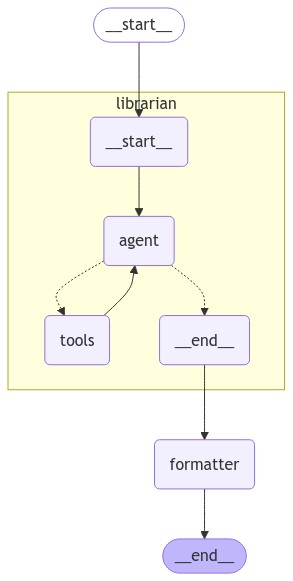

{'messages': [HumanMessage(content='Hi, my name is solace. I recently read The Rebound and I absolutely loved it! The plot twist, the sweet love, everything was there. Looking forward to reading more from the author.', additional_kwargs={}, response_metadata={}, id='398739b1-e678-437b-8f50-bb13db42202d'),
  AIMessage(content="Hello solace! I'm glad you enjoyed The Rebound. It's always great to find a book that ticks all the boxes. How can I assist you today?", additional_kwargs={}, response_metadata={}, id='007440b5-cb3e-4a8d-8500-23048e78b7a5'),
  HumanMessage(content="I'm actually looking for another book recommendation. Any suggestions?", additional_kwargs={}, response_metadata={}, id='4cfccce1-7132-4f2d-ac80-c15b53b56fcc'),
  AIMessage(content="Definitely! I recommend checking out Feral: Obsession (Volume 1). It's a captivating book with well-developed characters and a great storyline. I received an ARC of this book and it left me eagerly anticipating the next one.", additional_kwa

In [25]:
await recommend_agent_2(messages_pre, store, n=10)

### Multi agent


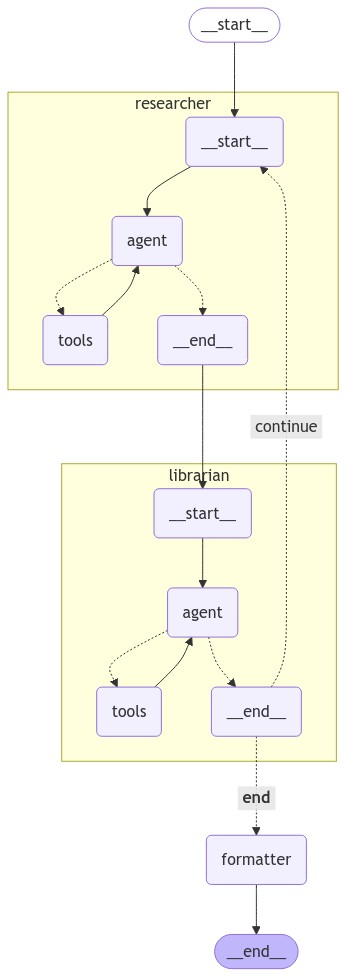

{'messages': [HumanMessage(content='Hi, my name is solace. I recently read The Rebound and I absolutely loved it! The plot twist, the sweet love, everything was there. Looking forward to reading more from the author.', additional_kwargs={}, response_metadata={}, id='ed2c82ee-943d-4127-9326-63ce859e0e65'),
  AIMessage(content="Hello solace! I'm glad you enjoyed The Rebound. It's always great to find a book that ticks all the boxes. How can I assist you today?", additional_kwargs={}, response_metadata={}, id='5021060a-b2d1-454d-901b-d1d3ddd092ba'),
  HumanMessage(content="I'm actually looking for another book recommendation. Any suggestions?", additional_kwargs={}, response_metadata={}, id='02f948da-9310-4c4d-aa54-1421c03dc11c'),
  AIMessage(content="Definitely! I recommend checking out Feral: Obsession (Volume 1). It's a captivating book with well-developed characters and a great storyline. I received an ARC of this book and it left me eagerly anticipating the next one.", additional_kwa

In [26]:
await recommend_multi_agent_2(messages_pre, store, n=10)

### Metrics

In [26]:
import os
import asyncio
import pickle
import numpy as np
from scripts.metrics import * 


In [16]:
if not os.path.exists("X_test.pkl"):
    np.random.seed(0)

    X_test = []

    while len(X_test) < 200:
        user_id = list(data.keys())[np.random.randint(len(data))]
        try:
            samples = get_sample(user_id, data)
            X_test.extend(samples)
        except Exception as e:
            pass
    
    with open("X_test.pkl", "wb") as f:
        pickle.dump(X_test, f)

else:
    with open("X_test.pkl", "rb") as f:
        X_test = pickle.load(f)


In [32]:
np.mean([len(x["history"]) for x in X_test])

57.24752475247525

### Zero shot

In [42]:
# ZERO SHOT

if os.path.exists("zero_shot_results.pkl"):
    with open("zero_shot_results.pkl", "rb") as f:
        results = pickle.load(f)
else:
    tasks = []
    for x in X_test:
        tasks.append(recommend_zero_shot(x["messages_pre"], n=10))

    results = await asyncio.gather(*tasks)

    with open("zero_shot_results.pkl", "wb") as f:
        pickle.dump(results, f)

In [43]:
total_count = 0
count_by_recommendation = []
for recommendation in results:
    inner_count = 0
    for item_name in recommendation:
        if item_name.lower() not in items:
            total_count += 1
            inner_count += 1
    count_by_recommendation.append(inner_count)

In [44]:
total_count, np.mean(count_by_recommendation)

(1263, 6.252475247524752)

In [56]:
metrics = {"recall@5": [], "recall@10": [], "ndcg@5": [], "ndcg@10": [], "novelty": []}

for x, y in zip(X_test, results):

    relevant_items = x["history"]
    recommended_items = y

    metrics["recall@5"].append(recall_at_k(relevant_items, recommended_items, 5))
    metrics["recall@10"].append(recall_at_k(relevant_items, recommended_items, 10))

    metrics["ndcg@5"].append(ndcg_at_k(relevant_items, recommended_items, 5))
    metrics["ndcg@10"].append(ndcg_at_k(relevant_items, recommended_items, 10))

    metrics["novelty"].append(novelty_at_k(recommended_items, item_interactions, 10))

for key in metrics:
    print(f"{key}: {np.mean(metrics[key])}")

recall@5: 0.0009498489411025066
recall@10: 0.002105677369567473
ndcg@5: 0.0291046320641227
ndcg@10: 0.034828696338545545
novelty: 62524.83454687444


### Agent

In [33]:
# Define a semaphore with a maximum number of concurrent tasks
semaphore = asyncio.Semaphore(10)  # Adjust 5 to your desired concurrency level

async def recommend_with_semaphore(messages_pre, store, n):
    # Use the semaphore to limit concurrency
    async with semaphore:
        return await recommend_agent_2(messages_pre, store, n)

In [ ]:
if os.path.exists("agent_results.pkl"):
    with open("agent_results.pkl", "rb") as f:
        results = pickle.load(f)
else:
    tasks = []
    for x in X_test:
        tasks.append(recommend_with_semaphore(x["messages_pre"], store, n=10))

    results = await asyncio.gather(*tasks)

    with open("agent_results.pkl", "wb") as f:
        pickle.dump(results, f)

In [40]:
retry_tasks = []
failed_indices = []  # To track the indices of failed tasks

for i, (x, y) in enumerate(zip(X_test, results)):
    if y["messages"] is None:  # Check for failure
        retry_tasks.append(recommend_with_semaphore(x["messages_pre"], store, n=10))
        failed_indices.append(i)

len(failed_indices)

0

In [34]:
# Retry failed tasks concurrently
if retry_tasks:
    retries = await asyncio.gather(*retry_tasks)

    # Update the results with retried outputs
    for index, retry_result in zip(failed_indices, retries):
        results[index] = retry_result

In [35]:
with open("agent_results_2.pkl", "wb") as f:
    pickle.dump(results, f)

In [42]:
# AGENT

metrics = {"recall@5": [], "recall@10": [], "ndcg@5": [], "ndcg@10": [], "novelty": []}

for x, y in zip(X_test, results):

    relevant_items = x["history"]
    recommended_items = y["messages"][-1].content
    recommended_items = list(map(lambda x: item_map.get(x.upper(), "OOV").lower(), recommended_items))

    metrics["recall@5"].append(recall_at_k(relevant_items, recommended_items, 5))
    metrics["recall@10"].append(recall_at_k(relevant_items, recommended_items, 10))

    metrics["ndcg@5"].append(ndcg_at_k(relevant_items, recommended_items, 5))
    metrics["ndcg@10"].append(ndcg_at_k(relevant_items, recommended_items, 10))

    metrics["novelty"].append(novelty_at_k(recommended_items, item_interactions, 10))

for key in metrics:
    print(f"{key}: {np.mean(metrics[key])}")

recall@5: 0.003372453835960675
recall@10: 0.004623979162985182
ndcg@5: 0.0856237293287052
ndcg@10: 0.09216631494777808
novelty: 594.7474586277139


In [51]:
total_count = 0
count_by_recommendation = []
for result in results:
    inner_count = 0
    for item_id in result["messages"][-1].content:
        if item_id.upper() not in item_map:
            total_count += 1
            inner_count += 1
    count_by_recommendation.append(inner_count)

In [52]:
total_count, np.mean(count_by_recommendation)

(3, 0.01485148514851485)

### Multi agent

In [54]:
# Define a semaphore with a maximum number of concurrent tasks
semaphore = asyncio.Semaphore(10)  # Adjust 5 to your desired concurrency level

async def recommend_with_semaphore(messages_pre, store, n):
    # Use the semaphore to limit concurrency
    async with semaphore:
        return await recommend_multi_agent_2(messages_pre, store, n)

In [ ]:
if os.path.exists("multi_agent_results.pkl"):
    with open("multi_agent_results.pkl", "rb") as f:
        results = pickle.load(f)
else:
    tasks = []
    for x in X_test:
        tasks.append(recommend_with_semaphore(x["messages_pre"], store, n=10))

    results = await asyncio.gather(*tasks)

    with open("multi_agent_results.pkl", "wb") as f:
        pickle.dump(results, f)

In [65]:
retry_tasks = []
failed_indices = []  # To track the indices of failed tasks

for i, (x, y) in enumerate(zip(X_test, results)):
    
    if y["messages"] is None:  # Check for failure
        retry_tasks.append(recommend_with_semaphore(x["messages_pre"], store, n=10))
        failed_indices.append(i)

len(failed_indices)

1

In [ ]:
# Retry failed tasks concurrently
if retry_tasks:
    retries = await asyncio.gather(*retry_tasks)

    # Update the results with retried outputs
    for index, retry_result in zip(failed_indices, retries):
        results[index] = retry_result

In [66]:
# MULTI AGENT

metrics = {"recall@5": [], "recall@10": [], "ndcg@5": [], "ndcg@10": [], "novelty": []}

for x, y in zip(X_test, results):

    if y["messages"] is None:
        continue

    relevant_items = x["history"]
    recommended_items = y["messages"][-1].content
    recommended_items = list(map(lambda x: item_map.get(x.upper(), "OOV").lower(), recommended_items))

    metrics["recall@5"].append(recall_at_k(relevant_items, recommended_items, 5))
    metrics["recall@10"].append(recall_at_k(relevant_items, recommended_items, 10))

    metrics["ndcg@5"].append(ndcg_at_k(relevant_items, recommended_items, 5))
    metrics["ndcg@10"].append(ndcg_at_k(relevant_items, recommended_items, 10))

    metrics["novelty"].append(novelty_at_k(recommended_items, item_interactions, 10))

for key in metrics:
    print(f"{key}: {np.mean(metrics[key])}")

recall@5: 0.0024242360137599313
recall@10: 0.003608480374319112
ndcg@5: 0.04951334653637099
ndcg@10: 0.054502912559994426
novelty: 11891.065800758644


In [77]:
total_count = 0
count_by_recommendation = []
ood = []
for result in results:
    inner_count = 0

    if result is None:
        continue

    if result["messages"] is None:
        continue

    for item_id in result["messages"][-1].content:
        if item_id.upper() not in item_map:
            ood.append(item_id)
            total_count += 1
            inner_count += 1
    count_by_recommendation.append(inner_count)

In [78]:
total_count, np.mean(count_by_recommendation)

(235, 1.1691542288557213)

In [85]:
results[25]

{'messages': [HumanMessage(content='Hi, my name is Greg Goodman. I really enjoyed reading "Those Who Wish Me Dead" by Michael Koryta. The story was well-documented and had a great plot twist. I highly recommend it!', additional_kwargs={}, response_metadata={}, id='7fecc224-aa2b-4624-8387-111cb1933b1c'),
  AIMessage(content='Hello Greg! I\'m glad you enjoyed "Those Who Wish Me Dead". It\'s always exciting to come across a book that keeps you engaged. How can I assist you today?', additional_kwargs={}, response_metadata={}, id='4973d12c-e3d6-4ede-bf93-66ac29832381'),
  HumanMessage(content='Can you recommend another book for me?', additional_kwargs={}, response_metadata={}, id='f0a40ca2-bae1-4a34-b828-6c24cc69bf4f'),
  AIMessage(content='Sure! I think you might enjoy "The Passage: A Novel (Book One of The Passage Trilogy)" by Justin Cronin. It has received positive reviews, such as this one: "Strong premise but the author failed to deliver. Cronin bogged this reader down with excessive b

In [79]:
ood

["j.k. lasser's your income tax 2023",
 'tax-free wealth',
 "j.k. lasser's small business taxes 2021",
 'cashing out: win the wealth game by walking away',
 'launching financial grownups',
 'unlock your best life',
 'tipped: the life-changing guide to financial freedom for service industry professionals',
 'the couple next door by shari lapena',
 'the girl on the train by paula hawkins',
 'in the woods by tana french',
 'the wife between us by greer hendricks and sarah pekkanen',
 'the girl in the window',
 'everyone on this train is a suspect by benjamin stevenson',
 'the fury by alex michaelides',
 'the dirty life: on farming, food, and love by kristin kimball',
 'we are what we eat: a slow food manifesto by alice waters',
 'one-woman farm: my life shared with sheep, pigs, chickens, goats, and a fine fiddle by jenna woginrich',
 'growing a revolution: bringing our soil back to life by david r. montgomery',
 'local: the new face of food and farming in america',
 'eating for pleasure, 

# Metrics

In [9]:
import os
import sys
sys.path.append(os.path.abspath(".."))

In [10]:
import pickle
from scripts.metrics import * 

In [11]:
with open("zero_shot_results.pkl", "rb") as f:
    results_zero_shot = pickle.load(f)

with open("agent_results.pkl", "rb") as f:
    results_agent = pickle.load(f)

with open("multi_agent_results.pkl", "rb") as f:
    results_multi_agent = pickle.load(f)

In [12]:
with open("X_test.pkl", "rb") as f:
    X_test = pickle.load(f)


In [16]:
import asyncio
from openai import AsyncOpenAI
client = AsyncOpenAI()

async def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   response = await client.embeddings.create(input = [text], model=model)
   return response.data[0].embedding


In [18]:
def cosine_similarity(x, y):
    x = np.array(x)
    y = np.array(y)
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


async def get_profile(history: list):
    embeddings = []
    tasks = []
    for item in history:
        x = f"book '{item}'"
        tasks.append(get_embedding(x))
    embeddings = await asyncio.gather(*tasks)
    profile = np.mean(embeddings, axis=0)
    return profile

In [ ]:
for index, x in enumerate(X_test):
    print(f"Processing {index + 1}/{len(X_test)}")
    profile = await get_profile(x["history"])
    x["profile"] = profile

In [ ]:
embeddings_multi_agent = []
for index, result in enumerate(results_multi_agent):
    print(f"Processing {index + 1}/{len(results_multi_agent)}")
    if len(result) > 0:
        if result["messages"] is None:
            embeddings_multi_agent.append(None)
            continue
        recommended_items = result["messages"][-1].content
        for index, item in enumerate(recommended_items):
            if item.upper() in item_map:
                recommended_items[index] = item_map[item.upper()]
        embeddings_multi_agent.append(await get_profile(recommended_items))
    else:
        embeddings_multi_agent.append(None)

In [ ]:
embeddings_agent = []
for index, result in enumerate(results_agent):
    print(f"Processing {index + 1}/{len(results_agent)}")
    if len(result) > 0:
        recommended_items = result["messages"][-1].content
        for index, item in enumerate(recommended_items):
            if item.upper() in item_map:
                recommended_items[index] = item_map[item.upper()]
        embeddings_agent.append(await get_profile(recommended_items))
    else:
        embeddings_agent.append(None)

In [ ]:
embeddings_zero_shot = []
for index, result in enumerate(results_zero_shot):
    print(f"Processing {index + 1}/{len(results_zero_shot)}")
    if len(result) > 0:
        embeddings_zero_shot.append(await get_profile(x))
    else:
        embeddings_zero_shot.append(None)

In [50]:
novelty = 0
n = 0
for x, y in zip(embeddings_zero_shot, [x["profile"] for x in X_test]):
    if x is not None and y is not None:
        novelty += cosine_similarity(x, y)
        n += 1

print(novelty / n)

0.663605479687184


In [ ]:
novelty = 0
n = 0
for x, y in zip(embeddings_agent, [x["profile"] for x in X_test]):
    if x is not None and y is not None:
        novelty += cosine_similarity(x, y)
        n += 1

print(novelty / n)

0.7276900175787342


In [49]:
novelty = 0
n = 0
for x, y in zip(embeddings_multi_agent, [x["profile"] for x in X_test]):
    if x is not None and y is not None:
        novelty += cosine_similarity(x, y)
        n += 1

print(novelty / n)

0.7531312197303951


In [13]:
metrics = {"recall@5": [], "recall@10": [], "precision@5": [], "precision@10": [], "ndcg@5": [], "ndcg@10": [], "novelty": []}

for x, y in zip(X_test, results_zero_shot):

    relevant_items = x["history"]
    recommended_items = y

    metrics["recall@5"].append(recall_at_k(relevant_items, recommended_items, 5))
    metrics["recall@10"].append(recall_at_k(relevant_items, recommended_items, 10))

    metrics["precision@5"].append(precision_at_k(relevant_items, recommended_items, 5))
    metrics["precision@10"].append(precision_at_k(relevant_items, recommended_items, 10))

    metrics["ndcg@5"].append(ndcg_at_k(relevant_items, recommended_items, 5))
    metrics["ndcg@10"].append(ndcg_at_k(relevant_items, recommended_items, 10))

    metrics["novelty"].append(novelty_at_k(recommended_items, item_interactions, 10))

for key in metrics:
    print(f"{key}: {np.mean(metrics[key])}")

recall@5: 0.0009498489411025066
recall@10: 0.002105677369567473
precision@5: 0.008910891089108912
precision@10: 0.008910891089108912
ndcg@5: 0.0291046320641227
ndcg@10: 0.034828696338545545
novelty: 62524.83454687444


In [14]:
metrics = {"recall@5": [], "recall@10": [], "precision@5": [], "precision@10": [], "ndcg@5": [], "ndcg@10": [], "novelty": []}

for x, y in zip(X_test, results_agent):

    if y["messages"] is None:
        continue


    relevant_items = x["history"]
    #recommended_items = y
    recommended_items = y["messages"][-1].content
    recommended_items = list(map(lambda x: item_map.get(x.upper(), "OOV").lower(), recommended_items))


    metrics["recall@5"].append(recall_at_k(relevant_items, recommended_items, 5))
    metrics["recall@10"].append(recall_at_k(relevant_items, recommended_items, 10))

    metrics["precision@5"].append(precision_at_k(relevant_items, recommended_items, 5))
    metrics["precision@10"].append(precision_at_k(relevant_items, recommended_items, 10))

    metrics["ndcg@5"].append(ndcg_at_k(relevant_items, recommended_items, 5))
    metrics["ndcg@10"].append(ndcg_at_k(relevant_items, recommended_items, 10))

    metrics["novelty"].append(novelty_at_k(recommended_items, item_interactions, 10))

for key in metrics:
    print(f"{key}: {np.mean(metrics[key])}")

recall@5: 0.003372453835960675
recall@10: 0.004623979162985182
precision@5: 0.021782178217821784
precision@10: 0.016831683168316833
ndcg@5: 0.0856237293287052
ndcg@10: 0.09216631494777808
novelty: 594.7474586277139


In [15]:
metrics = {"recall@5": [], "recall@10": [], "precision@5": [], "precision@10": [], "ndcg@5": [], "ndcg@10": [], "novelty": []}

for x, y in zip(X_test, results_multi_agent):

    if y["messages"] is None:
        continue


    relevant_items = x["history"]
    recommended_items = y["messages"][-1].content
    recommended_items = list(map(lambda x: item_map.get(x.upper(), "OOV").lower(), recommended_items))

    metrics["recall@5"].append(recall_at_k(relevant_items, recommended_items, 5))
    metrics["recall@10"].append(recall_at_k(relevant_items, recommended_items, 10))

    metrics["precision@5"].append(precision_at_k(relevant_items, recommended_items, 5))
    metrics["precision@10"].append(precision_at_k(relevant_items, recommended_items, 10))

    metrics["ndcg@5"].append(ndcg_at_k(relevant_items, recommended_items, 5))
    metrics["ndcg@10"].append(ndcg_at_k(relevant_items, recommended_items, 10))

    metrics["novelty"].append(novelty_at_k(recommended_items, item_interactions, 10))

for key in metrics:
    print(f"{key}: {np.mean(metrics[key])}")

recall@5: 0.0024242360137599313
recall@10: 0.003608480374319112
precision@5: 0.017910447761194027
precision@10: 0.012935323383084578
ndcg@5: 0.04951334653637099
ndcg@10: 0.054502912559994426
novelty: 11891.065800758644
